# Generate ERA5 forcing: camels shapefile

This will consist of two parts in separate notebooks:
1. using a shapefile from Caravan
2. using your own shapefile!

ERA5 need 4 different inputs:
1. a shapefile
2. a time-window
3. a directory to save the data
4. and a type of forcing



## Caravan Shapefile

in eWaterCycle we provide access to the Caravan dataset, which contains all of the above data for all the catchments in the different Camels datasets. However, for two reasons, we don't use the rainfall and potential evaporation data from Caravan

1. This allows us to demonstrate how to generate forcing data for any model from ERA5 (working on ERA5Land) and from CMIP data
2. There is a known problem with the caravan evaporation data and we want to avoid using it here.

We thus only use the Caravan dataset to retrieve

- a shapefile of the region of interest, to be used as input for generating the forcing from ERA5
- the observational data of river discharge

Using the interactive maps at [eWaterCycle caravan map](https://www.ewatercycle.org/caravan-map/) one can easily retrieve the identifier of the catchment.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# Niceties
from rich import print

# General eWaterCycle
import ewatercycle
import ewatercycle.forcing

We will be using the same catchment from the Camels forcing from Caravan:

In [2]:
# The id of the camels region
camels_id = "camelsgb_33039"  # river: Bedford Ouse at Roxton, England

# The time-window of the experiment
experiment_start_date = "2000-08-01T00:00:00Z"
experiment_end_date = "2005-08-31T00:00:00Z"

In [3]:
# The path of the Caravan data
forcing_path_caravan = Path.home() / "forcing" / camels_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

Now if you ran the previous notebook (the one where you generate the forcing) just load the data, this saves time, and prevents an error!

In [4]:
'''Generating the camels forcing'''
# camels_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camels_id,
# )

'''Loading the camels forcing'''
camels_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(directory=forcing_path_caravan)

### Extracting the shapefile

Now we can easily extract the shapefile

In [5]:
shapefile = camels_forcing.shape

## ERA5 Forcing Generation

Now that we have the shapefile we can almost get the ERA5 forcing.
But first we need to define a new path.
And we need to pick what kind of forcing we want to generate, this depends on what model you want to use, currently these sources are supported:
1. LumpedMakkinkForcing
2. DistributedMakkinkForcing
3. DistributedUserForcing
4. GenericDistributedForcing
5. GenericLumpedForcing
6. HypeForcing
7. LisfloodForcing
8. LumpedUserForcing
9. MarrmotForcing
10. PCRGlobWBForcing
11. WflowForcing

More details can be found in the [documentation](https://ewatercycle.readthedocs.io/en/latest/user_guide/02_forcing.html). And also in the [models section](https://www.ewatercycle.org/getting-started/main/some_content/different_models.html).

For now we will use 'lumped Makkink forcing', this is needed for running an HBV model.

In [6]:
forcing_path_ERA5 = Path.home() / "forcing" / camels_id / "ERA5"
forcing_path_ERA5.mkdir(exist_ok=True)

When we generate the ERA5 object we use data that we have stored locally on the SRC. This data spans from 1980-2020. Also note that when you already have the ERA5 forcing downloaded, it will throw errors.

In [7]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset="ERA5",
   start_time=experiment_start_date,
   end_time=experiment_end_date,
   shape=shapefile,
   directory=forcing_path_ERA5,
)

In [8]:
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2000-08-01T00:00:00Z',
    end_time='2005-08-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/forcing/camelsgb_33039/ERA5/work/diagnostic/script'),
    shape=PosixPath('/home/mmelotto/forcing/camelsgb_33039/caravan/camelsgb_33039.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2000-2005.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2000-2005.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2000-2005.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

So the LumpedMakkinkForcing stores the following:
1. pr: precipitation
2. tas: temperature
3. rsds: incoming shortwave radiation
4. evspsblpot: potential evaporation (note that this is calculated, using Makking)

We can also load the forcing data after we have generated it:

In [9]:
load_location = forcing_path_ERA5 / "work" / "diagnostic" / "script"  # this is needed because the data is stored in a sub-directory
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [10]:
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2000-08-01T00:00:00Z',
    end_time='2005-08-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/forcing/camelsgb_33039/ERA5/work/diagnostic/script'),
    shape=PosixPath('/home/mmelotto/forcing/camelsgb_33039/ERA5/work/diagnostic/script/camelsgb_33039.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2000-2005.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2000-2005.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2000-2005.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

## The data

We can easily plot the data now!

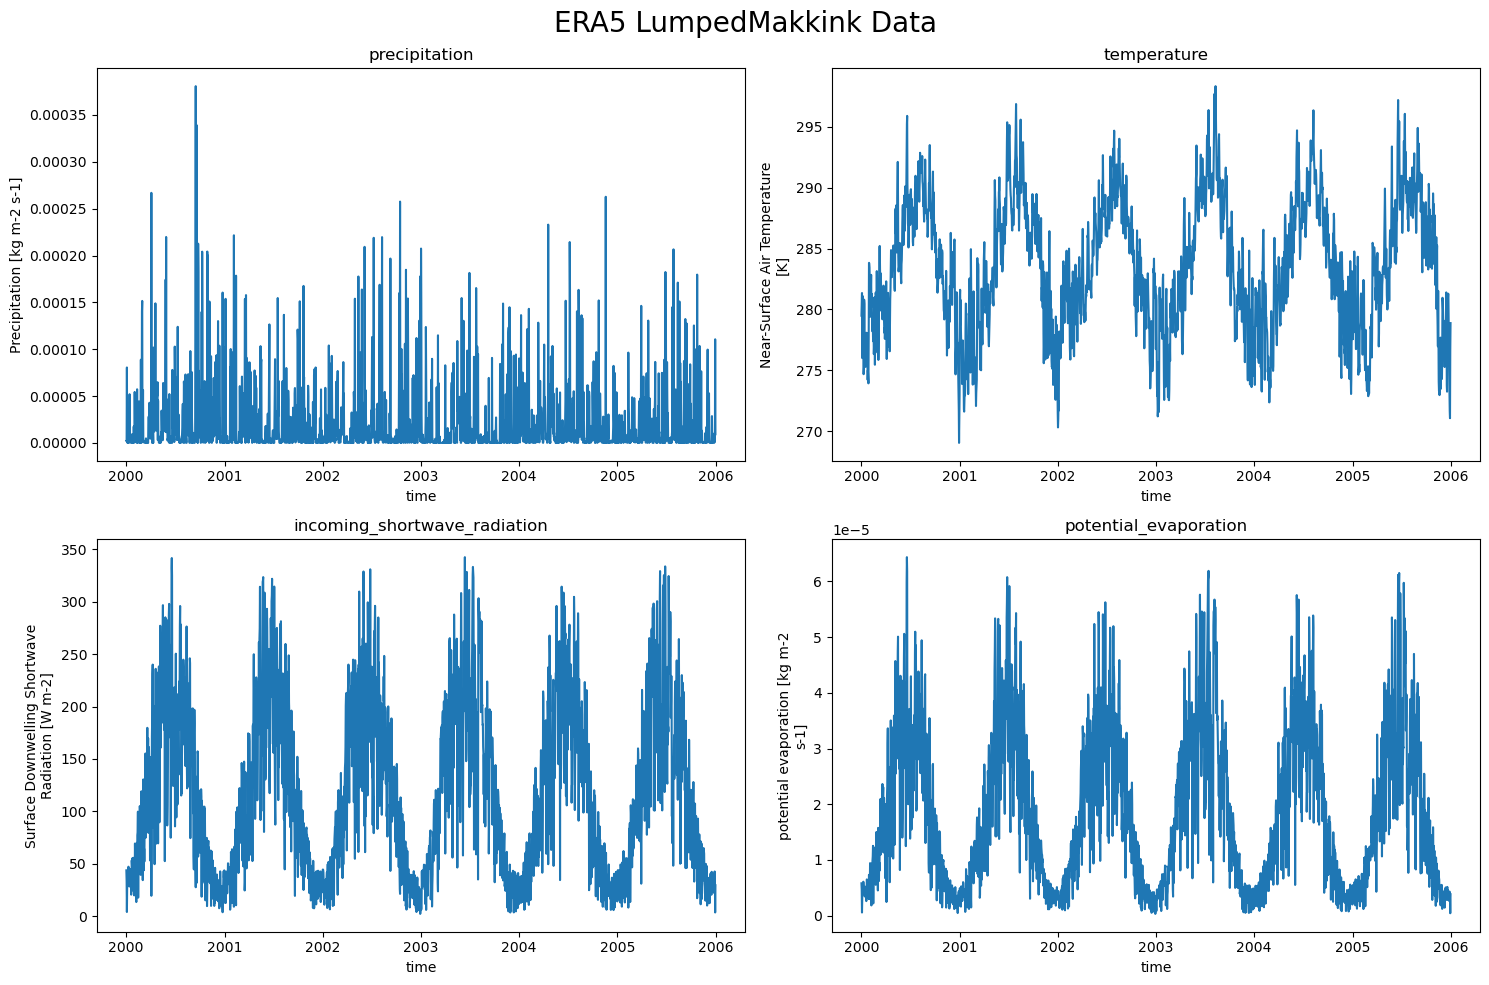

In [11]:
ERA5_data = {'precipitation pr': xr.open_dataset(ERA5_forcing['pr']),
             'temperature tas': xr.open_dataset(ERA5_forcing['tas']),
             'incoming_shortwave_radiation rsds': xr.open_dataset(ERA5_forcing['rsds']),
             'potential_evaporation evspsblpot': xr.open_dataset(ERA5_forcing['evspsblpot'])
}

plot_counter = 1
plt.figure(figsize=(15, 10))
for name, data in ERA5_data.items():
    plt.subplot(2,2, plot_counter)
    data[name.split(" ")[-1]].plot()
    plt.title(f"{name.split(" ")[0]}")
    plot_counter+=1

plt.suptitle("ERA5 LumpedMakkink Data", fontsize=20)
plt.tight_layout()